In [1]:

import numpy as np 
import pandas as pd 
import warnings 
warnings.filterwarnings("ignore")
import tensorflow as tf 


print(tf.__version__)

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM,Bidirectional
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras import Input
from tensorflow.keras.layers import Flatten, Reshape
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D,concatenate
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import initializers
import tensorflow.keras.backend as K


from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Activation
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam

import math
import pickle5 as pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


2.2.0


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession


gpus = tf.config.experimental.list_logical_devices('GPU')
print(gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu,True)
    except:
        print('checking gpu error')
print('checking GPUs')

config=tf.compat.v1.ConfigProto()
# config.gpu_options.visible_device_list= '0,1'
config.gpu_options.allow_growth=True

config.log_device_placement=True
# config.visible_device_list =2
sess=tf.compat.v1.Session(config=config)

tf.compat.v1.keras.backend.set_session(sess)




[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
checking gpu error
checking GPUs
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: TITAN X (Pascal), pci bus id: 0000:06:00.0, compute capability: 6.1



In [3]:
## data setting
sample_size = 10000
num_per_channel=3
x_column=150
y_column=150
channels=40
sample_shape= (num_per_channel, channels, x_column, y_column, )
z_dim = 100

In [4]:
def generator(img_shape, z_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=z_dim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(num_per_channel*x_column*y_column*channels, activation='tanh'))
    model.add(Reshape(img_shape))
    z = Input(shape=(z_dim,))
    img = model(z)
    return Model(z, img)

def discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='sigmoid'))
    img = Input(shape=img_shape)
    prediction = model(img)
    return Model(img, prediction)

discriminator = discriminator(sample_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
generator = generator(sample_shape, z_dim)
z = Input(shape=(100,))
img = generator(z)
discriminator.trainable = False
prediction = discriminator(img)
combined = Model(z, prediction)
combined.compile(loss='cosine_similarity', optimizer=Adam())

In [5]:
# training

In [6]:

losses = []
accuracies = []
def train(iterations, batch_size, sample_interval,xtrain, xtest):
    gen_images = []
    
    # Assign X_train to X_train_0 for augment non-cactus images
    # Assign X_train to X_train_1 for augment cactus images

    X_train = np.array(xtrain)
    X_test = np.array(xtest)
    real = np.ones((batch_size, 1))
#     real = np.random.choice(X_train, size=batch_size, replace=True, p=None)
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):
       
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
#         d_loss = discriminator.train_on_batch(gen_imgs, real)

        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        g_loss = combined.train_on_batch(z, real)

        if iteration % sample_interval == 0:
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iteration, d_loss[0], 100*d_loss[1], g_loss))
            losses.append((d_loss[0], g_loss))
            accuracies.append(100*d_loss[1])
            gen_images.append(sample_images(iteration))
    return gen_images

In [7]:


def sample_images(iteration, image_grid_rows=4, image_grid_columns=4):

    z = np.random.normal(0, 1, 
              (image_grid_rows * image_grid_columns, z_dim))

    gen_imgs = generator.predict(z)
    gen_imgs = 0.5 * gen_imgs + 0.5
            
    return gen_imgs



In [8]:
# Set iterations at least 10000 for good results
iterations = 200
batch_size = 8
sample_interval = 5
xtrain = np.load('8kfb_representation_samevalue.npy', allow_pickle=True)
print(xtrain.shape)
np.random.shuffle(xtrain)
split = math.floor(len(xtrain)*0.9)
xtrain, xtest = xtrain[:split], xtrain[split:]
gen_imgs = train(iterations, batch_size, sample_interval, xtrain,xtest)

(141, 3, 40, 150, 150)
0 [D loss: 0.691811, acc.: 56.25%] [G loss: -0.000011]
5 [D loss: 0.200082, acc.: 100.00%] [G loss: 0.000000]
10 [D loss: 0.052902, acc.: 100.00%] [G loss: 0.000000]
15 [D loss: 0.027366, acc.: 100.00%] [G loss: 0.000000]
20 [D loss: 0.047414, acc.: 100.00%] [G loss: 0.000000]
25 [D loss: 0.022910, acc.: 100.00%] [G loss: 0.000000]
30 [D loss: 0.000097, acc.: 100.00%] [G loss: 0.000000]
35 [D loss: 0.000441, acc.: 100.00%] [G loss: 0.000000]
40 [D loss: 0.000136, acc.: 100.00%] [G loss: 0.000000]
45 [D loss: 0.001607, acc.: 100.00%] [G loss: 0.000000]
50 [D loss: 0.000697, acc.: 100.00%] [G loss: 0.000000]
55 [D loss: 0.000255, acc.: 100.00%] [G loss: 0.000000]
60 [D loss: 0.005177, acc.: 100.00%] [G loss: 0.000000]
65 [D loss: 0.000647, acc.: 100.00%] [G loss: 0.000000]
70 [D loss: 0.000014, acc.: 100.00%] [G loss: 0.000000]
75 [D loss: 0.000625, acc.: 100.00%] [G loss: 0.000000]
80 [D loss: 0.000099, acc.: 100.00%] [G loss: 0.000000]
85 [D loss: 0.000102, acc.:

In [28]:
z = np.random.normal(0, 1, (batch_size, 100))
output = generator.predict(z)
print(output.shape)

(8, 3, 40, 150, 150)


In [33]:
print(np.max(output[0]))
print(output[0])

0.037492443
[[[[-1.22940447e-02  9.97096673e-03 -2.88914028e-03 ... -3.67864408e-03
    -1.73886381e-02 -6.78606192e-03]
   [-4.51845257e-03 -5.41636487e-03  1.02005918e-02 ... -6.54162653e-03
     1.25789875e-03  1.21418072e-03]
   [ 2.70152959e-04  5.65037178e-03  7.72465719e-03 ... -5.09661017e-03
    -4.40096017e-03  3.24813277e-03]
   ...
   [ 5.75957494e-03 -4.29797656e-05 -1.82234740e-03 ... -8.10639095e-03
     2.57230224e-03  1.20512582e-03]
   [ 1.48103312e-02  1.59240849e-02  1.83205307e-03 ...  7.01594306e-03
     8.09997073e-06  5.52846538e-03]
   [-1.41334999e-03  9.97486338e-03  2.03620810e-02 ...  6.06753281e-04
     8.48157797e-03  7.62519718e-04]]

  [[-6.07543439e-03  6.02018088e-03 -1.53814058e-03 ... -6.74199546e-05
     1.19807106e-03  1.55250484e-03]
   [-6.79252786e-04 -4.84004943e-03 -6.17891550e-04 ... -1.25236306e-02
     1.48608247e-02 -8.16428848e-03]
   [ 3.49368504e-03  5.85294748e-03  7.44537264e-03 ... -1.07471002e-02
     1.09754468e-03  5.29367570e-03

In [20]:
# replot from representation
from collections import defaultdict
def find_traj_samevalue(tensor):
#     print(tensor.shape)
    result_traj=[] #{traj}, traj is 2D, get the occupied points
    for snapshot in tensor:
        max_v = int(np.max(snapshot))
        if max_v==0:
            continue
        loc = np.where(snapshot==1)
        if loc[0].size==0:
            continue
        for i in range(len(loc[0])):
            result_traj.append([loc[0][i]+450, loc[1][i]-2450])
    return result_traj
            
    
def replot_from_representation(scene_tensor, lane_list, intersection_id, grid_boundary):

    veh, ped, cyc = scene_tensor[0], scene_tensor[1], scene_tensor[2]
    veh_traj = find_traj_samevalue(veh)
    ped_traj = find_traj_samevalue(ped)
    cyc_traj = find_traj_samevalue(cyc)
    
    plt.figure(figsize=(18,18))
    for lane in lane_list[intersection_id]:
        plt.plot(Test.map_api.get_lane_coords(lane)['xyz_right'][:,0], Test.map_api.get_lane_coords(lane)['xyz_right'][:,1],
                 color='g',linewidth=1,label=lane)
        plt.plot(Test.map_api.get_lane_coords(lane)['xyz_left'][:,0], Test.map_api.get_lane_coords(lane)['xyz_left'][:,1],
                 color='g',linewidth=1)
#         print("lane coordinates right", Test.map_api.get_lane_coords(lane)['xyz_right'][:,0])
    x_mesh, y_mesh = get_grid(intersection_id, grid_boundary)
#     print(x_mesh.shape, y_mesh[:,1])
    plt.plot(x_mesh, y_mesh, c='grey', linewidth=0.1) # use plot, not scatter
    plt.plot(np.transpose(x_mesh), np.transpose(y_mesh),c='grey', linewidth=0.1) # add this here
#     plt.title(intersection_id,fontsize=30)
    

    veh_traj = np.array(veh_traj)
    if len(veh_traj)>0:
        plt.scatter(veh_traj[:,0],veh_traj[:,1], c='b',s=1)
   
    ped_traj = np.array(ped_traj)
    if len(ped_traj)>0:
        plt.scatter(ped_traj[:,0],ped_traj[:,1], c='orange',s=1)
   
    cyc_traj = np.array(cyc_traj)
    if len(cyc_traj)>0:
        plt.scatter(cyc_traj[:,0],cyc_traj[:,1], c='cyan',s=1)
#     if veh is not None:
#         for traj in veh: plt.plot(traj[:,0],traj[:,1], c='b',linewidth=0.5)
#     if ped is not None:
#         for traj in ped: plt.scatter(traj[:,0],traj[:,1], c='orange',linewidth=0.5)
#     if cyc is not None:
#         for traj in cyc: plt.plot(traj[:,0],traj[:,1], c='cyan',linewidth=0.5)
    plt.axis('off')
    plt.show()
    
    

In [21]:
import sys 
# locate to the working folder
# sys.path.append("D:\\GitHub\\Clone\\planning\\ruixuan")
from ruixuan.turning_scene import *
from l5kit.rasterization.rasterizer_builder import _load_metadata
import time
import pickle
import math

In [22]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "/home/lab1/repo/planning/prediction-dataset"
# get config
cfg = load_config_data("/home/lab1/repo/planning/ruixuan/visualisation_config.yaml")
print(cfg)

dm = LocalDataManager()
dataset_path = dm.require(cfg["val_data_loader"]["key"])
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()
print(zarr_dataset)

rast = build_rasterizer(cfg, dm)
ego_dataset = EgoDataset(cfg, zarr_dataset, rast)
# agent_dataset = AgentDataset(cfg, zarr_dataset, rast)
# Obatin the information from semantic map

semantic_map_filepath = dm.require(cfg["raster_params"]["semantic_map_key"])
dataset_meta = _load_metadata(cfg["raster_params"]["dataset_meta_key"], dm)
world_to_ecef = np.array(dataset_meta["world_to_ecef"], dtype=np.float64)
Map_Api = MapAPI(semantic_map_filepath, world_to_ecef)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'future_num_frames': 50, 'step_time': 0.1}, 'raster_params': {'raster_size': [320, 320], 'pixel_size': [0.5, 0.5], 'ego_center': [0.6, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False, 'set_origin_to_bottom': True}, 'val_data_loader': {'key': 'scenes/train.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}}
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+------

In [23]:
# Manully find the lane id in Map_Api for "lane_merge" and "8KfB"
lane_list = {}
junction_boundary = {}
# extend lane sequences
lane_list['lane_merge'] = ['ADrl',"oFEC",'m0JU','iQgg','M5V5','/Pgg','FFEC','XHTU']
lane_list['8KfB'] = ['/24B','6p63','FV1O','MV/U','SxVb','TG2b','TZZv','ZnUV','bH1o','dddQ','nXc0','zHjP','SD8o','vC8o']
junction_boundary['lane_merge'] = [(-940,1380),(-940,1480),(-880,1380),(-880,1480)]
junction_boundary['8KfB'] = [(500,-2420),(500,-2360),(560,-2360),(560,-2420)]
# junction_boundary['8KfB'] = [(450,-2400),(500,-2360),(560,-2360),(560,-2420)]

grid_boundary={}
grid_boundary['8KfB']={'X':[450,600], 'Y':[-2450, -2300]}

In [24]:
class Trajectory(Scene):
    
    def __init__(self, dataset, Map_Api):
        super(Trajectory, self).__init__(dataset, Map_Api)
        self.label_name = ['Car','Van','Tram','Bus','Truck','EV','OV','Bicycle',\
                           'Motorcycle','Cyclist','Motorcyclist','Pedestrian']
        self.label_idx = list(range(3,15))
        self.label_dict = dict(zip(self.label_name, self.label_idx))
        self.all_traffic_control = None
        self.Traffic_Control = None

    def generate_info_from_MAP(self):
        self.all_junctions = self.get_elements("junction")
        self.all_lanes = self.get_elements("lane")
        self.all_traffic_control = self.get_elements("traffic_control_element")
        self.Lane = {self.map_api.id_as_str(lane.id):lane.element.lane for lane in self.all_lanes}
        self.Junction = {self.map_api.id_as_str(junction.id):junction for junction in self.all_junctions}
        self.Traffic_Control = {self.map_api.id_as_str(traffic_control.id):traffic_control.element for traffic_control in self.all_traffic_control}
        
        for junction in self.all_junctions:
            self.Junction_Lane[self.map_api.id_as_str(junction.id)] = []

            for lane in junction.element.junction.lanes:
                self.Junction_Lane[self.map_api.id_as_str(junction.id)].append(self.map_api.id_as_str(lane))

            self.Junction_Lane[self.map_api.id_as_str(junction.id)] = set(self.Junction_Lane[self.map_api.id_as_str(junction.id)])
        
        self.junction_scene = dict.fromkeys(list(self.Junction.keys()), [])
        self.junction_turning_scene = dict.fromkeys(list(self.Junction.keys()), {})
        for key in self.Junction.keys():
            self.junction_turning_scene[key] = {'Turning Left': [], 'Turning Right': []}    
        
        
    def label_loc_check(self, target_label):
    
        agent_id_list = self.agent_list[self.label_dict[target_label]-3]

        for agent_id in agent_id_list:
            agent_loc = self.agent_centroid[np.where(self.agent_id==agent_id)[0]]
            for centroid in agent_loc:
                if self.Junction_region.contains(Point(centroid[0],centroid[1])):
                    return True
    
    def junction_lane_visualize(self, junction_id):
        
        plt.figure(figsize=(18,18))
        
        lane_list = self.Junction_Lane[junction_id]
        
        for lane in lane_list:
            plt.plot(self.map_api.get_lane_coords(lane)['xyz_left'][:,0].tolist()+ self.map_api.get_lane_coords(lane)['xyz_right'][:,0].tolist(),
                        self.map_api.get_lane_coords(lane)['xyz_left'][:,1].tolist()+ self.map_api.get_lane_coords(lane)['xyz_right'][:,1].tolist(),
                        marker='x', label = lane)

        plt.axis("equal")
        plt.grid(which='both')
        plt.legend(fontsize=20)
        axes = plt.gca()  
    
                
    def agent_trajectory(self, scene, target_label, junction_boundary):

        self.scene = scene
        self.target_label = target_label
#         self.junction = junction
        # region for junction "sGK1"
#         junction_boundary = {junction:[(300,-1150),[300,-1100],(340,-1100),(340,-1150)]}

        # region for junction "8KfB"
#         junction_boundary = {junction:[(500,-2420),(500,-2360),(560,-2360),(560,-2420)]}
        
        # region for lane merge
#         junction_boundary = {junction:[(-940,1380),(-940,1480),(-880,1380),(-880,1480)]}

        self.Junction_region = Polygon(junction_boundary)

        self.agent_list = []
        frame_interval = self.dataset.scenes[scene]['frame_index_interval']
        agent_interval_begin = self.dataset.frames[frame_interval[0]]['agent_index_interval'][0]
        agent_interval_end = self.dataset.frames[frame_interval[1]-1]['agent_index_interval'][1]
        self.agent_id = self.dataset.agents[agent_interval_begin:agent_interval_end]['track_id']
        agent_label_prob = self.dataset.agents[agent_interval_begin:agent_interval_end]['label_probabilities']
        self.agent_centroid = self.dataset.agents[agent_interval_begin:agent_interval_end]['centroid']

        for label in self.label_idx:
            valid_idx = np.where(agent_label_prob[:,label]>0.5)[0]
            valid_id = set(self.agent_id[valid_idx])
            self.agent_list.append(list(valid_id))

        if len(self.agent_list[self.label_dict[target_label]-3])>0 and self.label_loc_check(target_label):
            return [scene]
        else:
            # print('Not feasible scene')
            return []
        
    def get_agent_traj(self, scene, target_label, junction, lane_list):
        veh_traj, ped_traj, cyclist_traj=[], [], [] 
        print(self.label_dict, self.label_dict[target_label])
        for idx, agent_label in enumerate(self.agent_list):
            print("xxx", idx, agent_label)
            for agent in agent_label:
                agent_loc = self.agent_centroid[np.where(self.agent_id==agent)[0]]
                if idx != self.label_dict[target_label]-3 and agent_loc.shape[0] > 30  \
                and np.linalg.norm(agent_loc[0,:]-agent_loc[-1,:]) > 5:
                    veh_traj.append(agent_loc)
#                     plt.plot(agent_loc[:,0],agent_loc[:,1],label='Agent ID '+str(agent)+': '\
#                              +self.label_name[idx], color=colors[idx])

                elif idx== self.label_dict[target_label]-3:
                    ped_traj.append(agent_loc)
        veh_traj, ped_traj, cyclist_traj = np.array(veh_traj), np.array(ped_traj), np.array(cyclist_traj)
        return veh_traj, ped_traj,cyclist_traj
#                     plt.plot(agent_loc[:,0],agent_loc[:,1], color=colors[idx], marker='*')
            
            
            
    def trajectory_junction_visualize(self, scene, target_label, junction, lane_list):
        
        frame_interval = self.dataset.scenes[scene]['frame_index_interval']
        
        plt.figure(figsize=(18,18))

        for lane in lane_list:
            plt.plot(self.map_api.get_lane_coords(lane)['xyz_right'][:,0], self.map_api.get_lane_coords(lane)['xyz_right'][:,1],
                     color='k',linewidth=5, alpha=0.2)
            plt.plot(self.map_api.get_lane_coords(lane)['xyz_left'][:,0], self.map_api.get_lane_coords(lane)['xyz_left'][:,1],
                     color='k',linewidth=5, alpha=0.2)

        cmap = plt.get_cmap('gnuplot')    
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
         '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','maple','yellowgreen'] 

        for idx, agent_label in enumerate(self.agent_list):
            for agent in agent_label:
                agent_loc = self.agent_centroid[np.where(self.agent_id==agent)[0]]
                if idx != self.label_dict[target_label]-3 and agent_loc.shape[0] > 30  and np.linalg.norm(agent_loc[0,:]-agent_loc[-1,:]) > 5:
                    plt.plot(agent_loc[:,0],agent_loc[:,1],label='Agent ID '+str(agent)+': '+self.label_name[idx], color=colors[idx])

                elif idx== self.label_dict[target_label]-3:
                    plt.plot(agent_loc[:,0],agent_loc[:,1], color=colors[idx], marker='*')

        ego_translation = self.frames[frame_interval[0]:frame_interval[1]]['ego_translation']
        plt.plot(ego_translation[:,0],ego_translation[:,1],label='Ego',color='r')
        turn = ' Left Turn' if rotation33_as_yaw(self.frames[frame_interval[0]]['ego_rotation']) - rotation33_as_yaw(self.frames[frame_interval[1]-1]['ego_rotation']) < 0 else ' Right Turn'

        plt.axis("equal")
        plt.grid(which='both')
        plt.legend(fontsize=20,loc='best')
        plt.title('Trajectory : Scene '+str(scene)+turn+' at Junction '+junction, fontsize=30)
        axes = plt.gca()
        
#     def agents_state_find(self, scene, output_array, target_agent_type_list):
        
#         frame_interval = .dataset.scenes[scene]['frame_index_interval']
        
#         cars_list = target_agent_type_list[0]
#         pedestrian_list = target_agent_type_list[1]
        
#         for agent_list in target_agent_type_list:
#             for agent in agent_list:
#                     agent_loc = self.agent_centroid[np.where(self.agent_id==agent)[0]]
#                     if idx != self.label_dict[target_label]-3 and agent_loc.shape[0] > 30  and np.linalg.norm(agent_loc[0,:]-agent_loc[-1,:]) > 5:
#                         for frame in frames

#                     elif idx== self.label_dict[target_label]-3:
#                         plt.plot(agent_loc[:,0],agent_loc[:,1], color=colors[idx], marker='*')

In [25]:
Test = Trajectory(zarr_dataset, Map_Api)
Test.generate_info_from_MAP()

In [26]:
def get_grid(intersection_id,grid_boundary):
    x = grid_boundary[intersection_id]['X']
    y = grid_boundary[intersection_id]['Y']
    x_ = np.linspace(x[0], x[1],500)
    y_ = np.linspace(y[0], y[1],500)
    x_mesh, y_mesh = np.meshgrid(x_, y_)
    return x_mesh, y_mesh

def locate_in_mesh(x_mesh, y_mesh, point):
    x, y = point[0], point[1]
    result=[]
#     print(x, y, x_mesh[0], x_mesh[-1], y_mesh[0], y_mesh[-1])
    if x>x_mesh[-1] or x<x_mesh[0] or y>y_mesh[-1] or y<y_mesh[0]:
        return None
    result = [math.floor(x-x_mesh[0]), math.floor(y-y_mesh[0])]
    return result

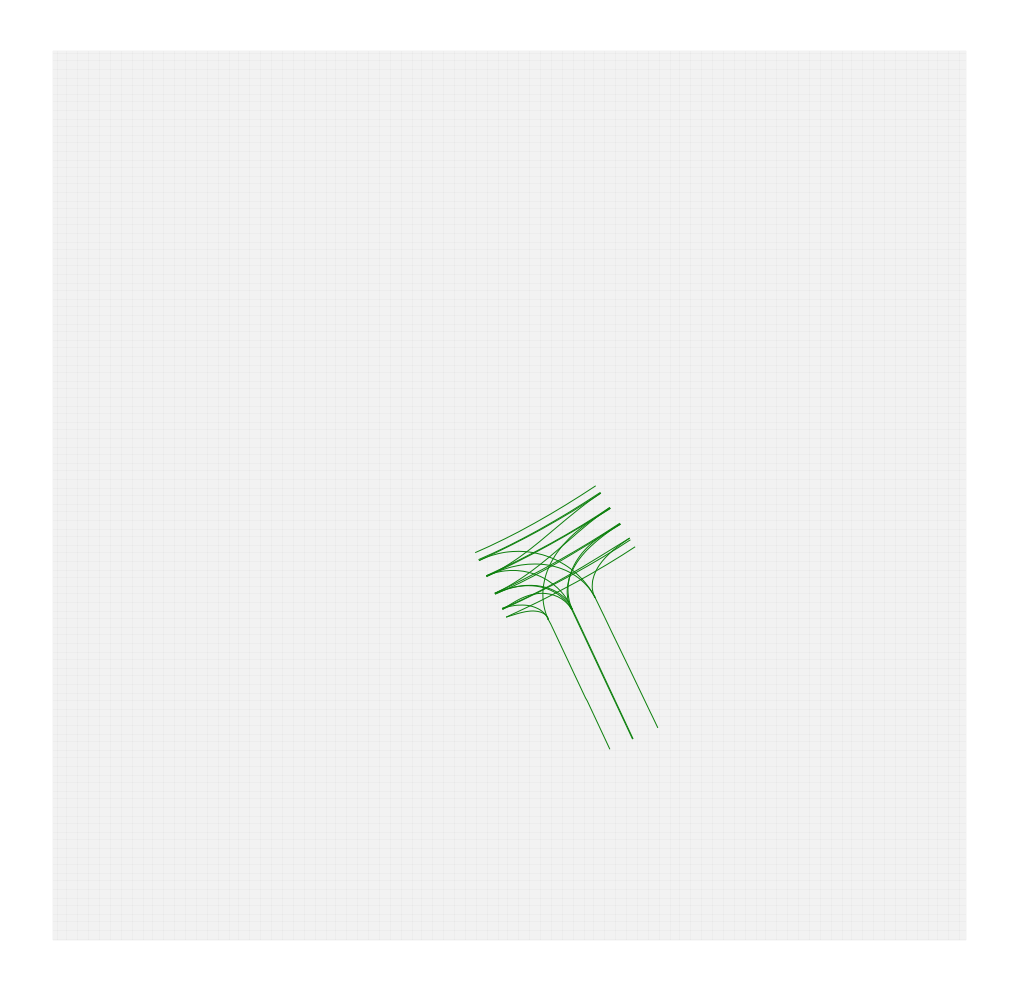

In [27]:
replot_from_representation(output[2], lane_list=lane_list, intersection_id='8KfB',  \
                           grid_boundary=grid_boundary)